# overview plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sstats.hfreq as hf
import sstats.tseries as ts

print_figs = True

---

## Low frequency signal

In [2]:
u = hf.low_frequency_signal()

In [3]:
u.autocorrelation

U**2*exp(-Abs(tau)/T)

In [4]:
u.spectrum

2*T*U**2/(T**2*omega**2 + 1)

In [5]:
# check Parseval: !!! 2 pi factor required
from sympy import oo, pi
u.spectrum.integrate((u.omega, -oo, oo)) /2/pi

U**2

In [6]:
# value at 0 frequency
u.spectrum.subs({u.omega:0})

2*T*U**2

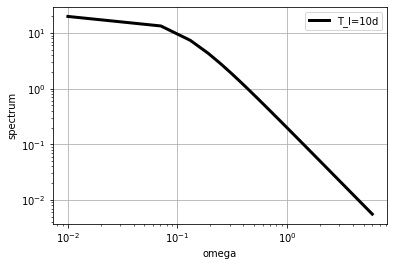

In [7]:
u.plot_spectrum(label='T_l=10d', color='k')
# for multiple parameter values:
#E = u.evaluate_spectrum()
#E

if print_figs:
    plt.savefig('figs/overview_low_spectrum.png')

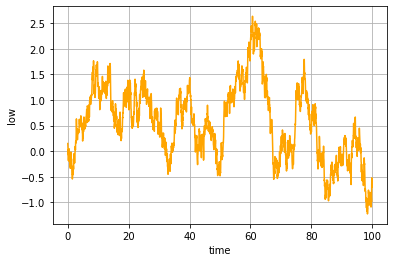

In [8]:
u_syn = u.generate_tseries(seed=0).persist()
u_syn.plot(color='orange')
plt.grid()

if print_figs:
    plt.savefig('figs/overview_low_tseries.png')

/Users/aponte/Code/synthetic_stats/sstats/tseries.py:342: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_sizes={'lags': lags.size}, kwargs=kwargs)


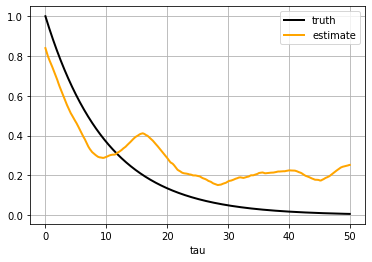

In [9]:
# statistical estimate
ds = (ts
      .correlate(u_syn, u_syn)
      .rename('autocorrelation')
      .to_dataset()
      .rename({'lags': 'tau'})
     )
# true autocorrelation
ds['true_autocorrelation'] = u.evaluate_autocorrelation(tau=ds.tau)

fig, ax = plt.subplots(1,1)
ds['true_autocorrelation'].plot(ax=ax, color='k', lw=2, label='truth')
ds['autocorrelation'].plot(ax=ax, color='orange', lw=2, label='estimate')
ax.grid()
ax.legend()
ax.set_ylabel(None)

if print_figs:
    plt.savefig('figs/overview_low_autocorrelation.png')

---

## High frequency signal

In [10]:
u = hf.high_frequency_signal()

In [11]:
u.autocorrelation

U**2*exp(-Abs(tau)/T)*cos(sigma*tau)

In [12]:
u.spectrum.factor()

2*T*U**2*(T**2*omega**2 + T**2*sigma**2 + 1)/((T**2*omega**2 - 2*T**2*omega*sigma + T**2*sigma**2 + 1)*(T**2*omega**2 + 2*T**2*omega*sigma + T**2*sigma**2 + 1))

In [13]:
# check Parseval: !!! 2 pi factor required
from sympy import oo, pi
_E = u.spectrum.subs({u.p["sigma"]: 2/u.p["T"]}) # hack, required (atan issues with sympy)
_I = _E.integrate((u.omega, 0, oo)) *2 /2/pi

In [14]:
# value at central frequency and within the limit of large (Txsigma)
u.spectrum.subs({u.omega: u.p["sigma"]}).limit(u.p["sigma"], oo)

T*U**2

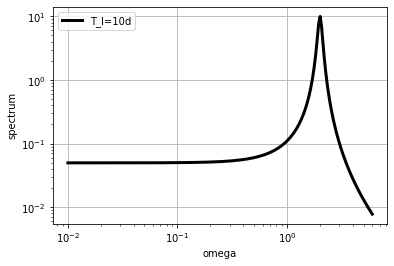

In [15]:
u.plot_spectrum(label='T_l=10d', color='k')
# for multiple parameter values:
#E = u.evaluate_spectrum()
#E

if print_figs:
    plt.savefig('figs/overview_high_spectrum.png')

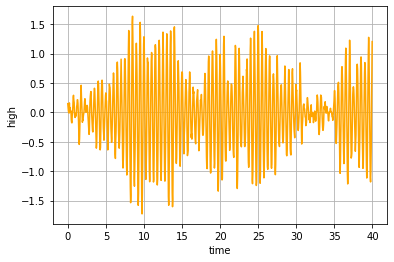

In [16]:
u_syn = u.generate_tseries(seed=0).persist()
u_syn.where(u_syn.time<40).plot(color='orange')
plt.grid()

if print_figs:
    plt.savefig('figs/overview_high_tseries.png')

/Users/aponte/Code/synthetic_stats/sstats/tseries.py:342: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_sizes={'lags': lags.size}, kwargs=kwargs)


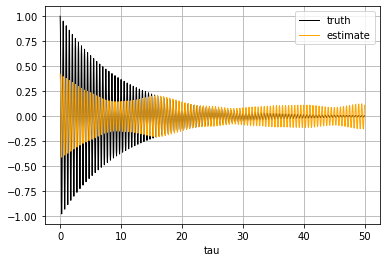

In [17]:
# statistical estimate
ds = (ts
      .correlate(u_syn, u_syn)
      .rename('autocorrelation')
      .to_dataset()
      .rename({'lags': 'tau'})
     )
# true autocorrelation
ds['true_autocorrelation'] = u.evaluate_autocorrelation(tau=ds.tau, 
                                                        sigma=2.*np.pi*u.p_values['sigma'],
                                                       )
# should not have to pass sigma above ...

fig, ax = plt.subplots(1,1)
ds['true_autocorrelation'].plot(ax=ax, color='k', lw=1, label='truth')
ds['autocorrelation'].plot(ax=ax, color='orange', lw=1, label='estimate')
ax.grid()
ax.legend()
ax.set_ylabel(None)

if print_figs:
    plt.savefig('figs/overview_high_autocorrelation.png')

---
## low + high

In [18]:
u_low = hf.low_frequency_signal()
u_high = hf.high_frequency_signal()
u = hf.add(u_low,u_high, labels=['low', 'high'])

In [19]:
u.autocorrelation

U_high**2*exp(-Abs(tau)/T_high)*cos(sigma_high*tau) + U_low**2*exp(-Abs(tau)/T_low)

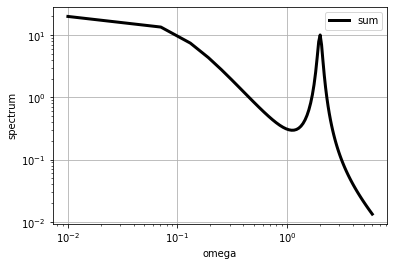

In [20]:
p_values = {**{p:1. for p in u.p if p[0]=='U'},
                             **{p:10. for p in u.p if p[0]=='T'},
                             'sigma_high': 2.,
                            }

u.plot_spectrum(eval_kwargs=p_values, 
                label='sum',
                color='k'
               )
# for multiple parameter values:
#E = u.evaluate_spectrum()
#E

#if print_figs:
#    plt.savefig('figs/overview_lowhigh_spectrum.png')